# Todo

* test all for rerun_analysis = True - mostly tested, need to run the long ones
* move all functions to function files
* [MAYBE] add venn for ortholog only genes
* update all plots to latest versions
* make sure all points in text are covered here in the order presented.

**DONE**  
* plot control results - DONE
* test all for rerun_analysis = False - DONE

THIS NOTEBOOK SHOULD PRODUCE ALL PLOTS FOR FIGURE 2 + RELEVANT EXTENDED DATA FIGURES

In [1]:
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from netcoloc import netprop_zscore, netprop


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [2]:
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/")

In [3]:
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *
from plotting_functions import *

In [4]:
num_reps=1000
adj_type='bonf'
rerun_analysis=True

# Load Input Data

## Load human and rat BMI seed genes

In [5]:
## Load the seed genes
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [6]:
seed_dict = {'hBMI': seed_bin_human_BMI, 'rBMI': seed_bin_rat_BMI}

## Load molecular interaction network

In [11]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


# Gene level overlap

In [12]:
def direct_overlap(all_nodes, seeds1, seeds2, labels=["Human", "Rat"], trait=""):
    hyper = hypergeom(M=len(all_nodes), n=len(seeds1), N=len(seeds2))
    intersect = set(seeds1).intersection(set(seeds2))
    p_intersect = hyper.sf(len(intersect))
    venn2([len(seeds1)-len(intersect), len(seeds2)-len(intersect), len(intersect)], labels,
     set_colors=('skyblue', 'purple'), alpha=0.7)
    _ = plt.title("-".join(labels) + " " +trait +" seed gene overlap, p="+str(p_intersect))

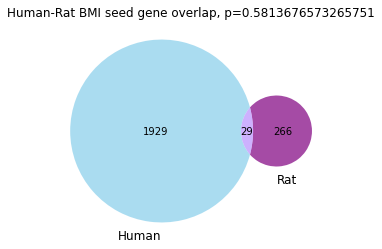

In [13]:
direct_overlap(pc_nodes, seed_bin_human_BMI, seed_bin_rat_BMI, trait="BMI")

# Perform BMI network colocalization

In [14]:
# precalculate network propagation heats
if rerun_analysis:
    w_prime = netprop.get_normalized_adjacency_matrix(G_PC, conserve_heat=True, weighted=False)
    indiv_heats = netprop.get_individual_heats_matrix(w_prime, alpha=0.5)

## Calculate Z-scores

In [15]:
z_dict = {}

### Human BMI

In [19]:
if rerun_analysis:
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    BMI_samples = calculate_heat_zscores_with_sampling(BMI_pascal_results, pc_nodes, indiv_heats, G_PC, trait="BMI",
                                                            out_path=DATADIR+"outputs/")
    z_human_bin_BMI = get_consensus_z_scores(BMI_samples, 0.75)
else:  # use pre-calculated results
    z_human_bin_BMI = get_consensus_z_scores(DATADIR+'outputs/z_human_bin_BMI_SAMPLED_500_100_weighted.tsv')
z_dict['hBMI'] = z_human_bin_BMI

### Rat BMI

In [34]:
if rerun_analysis:
    z_rat_BMI = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BMI,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BMI[0], columns=["z"]).to_csv(DATADIR+"outputs/z_rat_BMI_rerun.tsv", sep="\t", index=True)
    z_dict['rBMI'] = pd.DataFrame(z_rat_BMI[0], columns=["z"])
else:
    out_name = 'rat_BMI_'+ratThresh
    z_rat_BMI=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                          index_col='gene',names=['gene','z'], header=0)
    z_dict['rBMI'] = z_rat_BMI

  0%|          | 0/1000 [00:00<?, ?it/s]

## Permutation Analysis

In [44]:
observed_BMI, permuted_BMI = calculate_mean_z_score_distribution(z_dict['rBMI'], z_dict['hBMI'], num_reps=10000,
                                                       zero_double_negatives=False, overlap_control="bin",
                                                       seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [01:01<00:00, 162.01it/s]


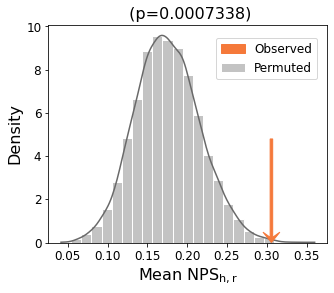

In [45]:
plot_permutation_histogram(permuted_BMI, observed_BMI,'', 'Mean $NPS_{h,r}$',color="dimgrey", arrow_color="#F5793A")
plt.savefig(FIGDIR + "ratBMI_humanBMI_mean_NPS_histogram_400dpi.png",dpi=400, bbox_inches="tight")

In [48]:
observed_BMI_sz, permuted_BMI_sz = calculate_expected_overlap(z_dict['rBMI'], z_dict['hBMI'], 
                                                            z_score_threshold=3, z1_threshold=1.0,
                                                            z2_threshold=1.0, num_reps=10000, plot=False, 
                                                            overlap_control="bin",
                                                            seed1=seed_dict['rBMI'], seed2=seed_dict['hBMI'])

Overlap seed genes: 29


100%|██████████| 10000/10000 [02:14<00:00, 74.11it/s]


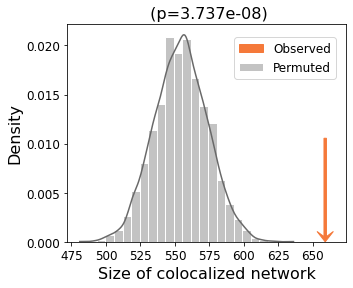

In [49]:
plot_permutation_histogram(permuted_BMI_sz, observed_BMI_sz,'', 'Size of colocalized network', color="dimgrey",
                          arrow_color="#F5793A")
plt.savefig(FIGDIR + "ratBMI_humanBMI_netcoloc_size_histogram_400dpi.png",dpi=400, bbox_inches="tight")

## Visualize results for BMI network colocalization

In [53]:
# compile_results
netcoloc_data = pd.DataFrame(z_dict['hBMI']).join(z_dict['rBMI'], lsuffix="_human", rsuffix="_rat")
netcoloc_data["human_seed"] = netcoloc_data.index.isin(seed_bin_human_BMI) * 1 
netcoloc_data["rat_seed"] = netcoloc_data.index.isin(seed_bin_rat_BMI) * 1 
netcoloc_data["hue"] = netcoloc_data.apply(lambda x: "#F5793A" if (x.z_human > 1) and (x.z_rat > 1) 
                                           and (x.z_human * x.z_rat > 3) else "grey", axis=1)
data_non_seed = netcoloc_data.loc[((netcoloc_data.rat_seed ==0) & (netcoloc_data.human_seed==0))]

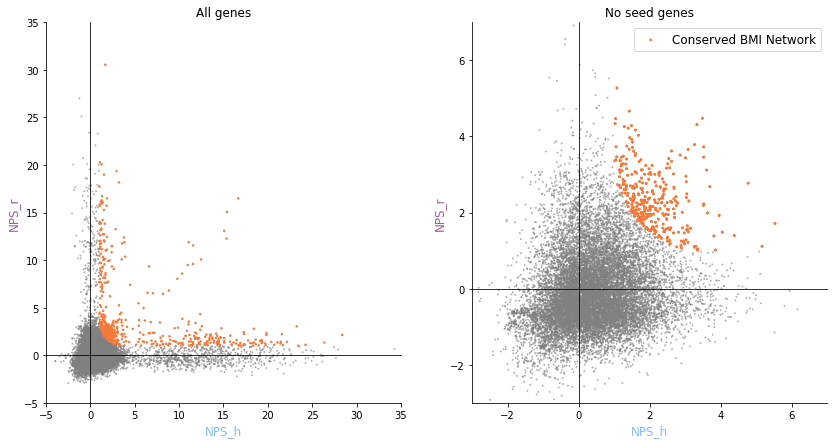

In [54]:
## scatter plot of species NPS scores 
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(14,7))
ax1.scatter(data=netcoloc_data, x="z_human", y="z_rat", color="hue", 
                s=[1 if netcoloc_data.hue[i]=="grey" else 2 for i in range(len(netcoloc_data))], 
                alpha=[0.5 if netcoloc_data.hue[i]=="grey" else 1 for i in range(len(netcoloc_data))], 
                zorder=0, label=None)
ax1.spines['left'].set(position=('data', -5), zorder=2)
ax1.spines['bottom'].set(position=('data', -5), zorder=2)
ax1.set_xlabel("NPS_h", zorder=4, fontsize=12, color="#85c0F9")
ax1.set_ylabel("NPS_r", fontsize=12, color="#A95AA1")
ax1.spines['top'].set_position(('data', 0.0))
ax1.spines['right'].set_position(('data', 0.0))
ax1.set_xlim((-5, 35))
ax1.set_ylim((-5, 35))
_ =ax1.set_title("All genes")


ax2.scatter(data=data_non_seed, x="z_human", y="z_rat", color="hue", 
                s=[1 if data_non_seed.hue[i]=="grey" else 3 for i in range(len(data_non_seed))], 
                alpha=[0.5 if data_non_seed.hue[i]=="grey" else 1 for i in range(len(data_non_seed))], 
                zorder=0, label=None)
ax2.scatter(data = data_non_seed[data_non_seed.hue != "grey"], x="z_human", y="z_rat", color="hue", s=3, alpha=1, 
                zorder=1, label= "Conserved BMI Network" )

ax2.set_ylabel("NPS_r", fontsize=12, color="#A95AA1")
ax2.set_xlim((-3, 7))
ax2.set_ylim((-3, 7))
ax2.spines['left'].set(position=('data', -3), zorder=2)
ax2.spines['bottom'].set(position=('data', -3), zorder=2)
ax2.set_xlabel("NPS_h", zorder=4, fontsize=12, color="#85c0F9")
ax2.spines['top'].set_position(('data', 0.0))
ax2.spines['right'].set_position(('data', 0.0))
_ =ax2.set_title("No seed genes")
plt.legend(fontsize=12)

plt.savefig(FIGDIR + "BMI_NPS_scatter_plots_conserved_network.png", bbox_inches="tight", dpi=400)

In [55]:
## Get gene sets meeting each of the thresholds
h_set = set(netcoloc_data[netcoloc_data.z_human > 1].index)
r_set = set(netcoloc_data[netcoloc_data.z_rat > 1].index)
b_set = set(netcoloc_data[netcoloc_data.hue != "grey"].index)

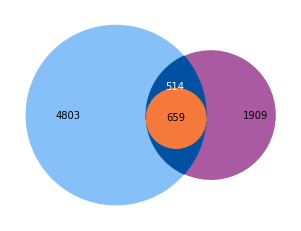

In [56]:
# create new venn diagram
c = venn3([h_set, r_set, b_set.intersection(h_set).intersection(r_set)], 
          set_colors = ["#85c0f9", "#a95aa1", "#f5793a"], alpha=1, set_labels=["", "", ""])
c.get_patch_by_id('111').set_color('#f5793a')
c.get_patch_by_id('110').set_color('#0051a2')
c.get_label_by_id('110').set_color('white')
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/UpdatedFigures/PostColoc_venn3_v2.png", dpi=400, bbox_inches="tight")

# Control analysis

def get_permutation_stats(obs, perm, trait, ci=0.95):
    transform = obs / perm
    avg = np.mean(transform)
    upper = np.quantile(transform, ci)
    lower = np.quantile(transform, 1-ci)
    p_value = get_p_from_permutation_results(obs, perm)
    return pd.DataFrame({"Mean":avg, "Upper":upper, "Lower":lower, "p":p_value}, index=[trait])

## Load control trait seed genes

### Positive Control Height/BL

In [57]:
seed_bin_human_height = load_human_seed_genes(DATADIR+'inputs/GIANT_standing_height_pascal.sum.genescores.txt', 
                                              pc_nodes, 'height')
seed_bin_rat_BL=pd.read_csv(DATADIR+'inputs/ratBL_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BL seeds:", len(seed_bin_rat_BL))

Number of height seeds: 6140
Number of rat BL seeds: 337


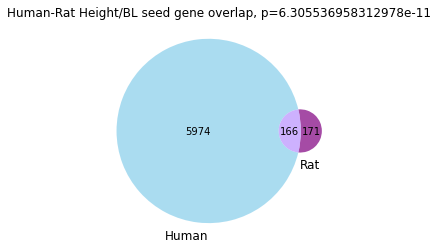

In [58]:
direct_overlap(pc_nodes, seed_bin_human_height, seed_bin_rat_BL, trait="Height/BL")

### Negative Controls

In [59]:
# Human control trait seed genes
seed_bin_human_AR = pd.read_csv(DATADIR+'inputs/humanAR_seed_PASCAL'+'_'+adj_type+'_relaxed.txt',
                               sep="\t")['0'].tolist() # Arthritis
seed_bin_human_BP1 = pd.read_csv(DATADIR+'inputs/humanBP1_seed_PASCAL'+'_'+adj_type+'_relaxed.txt',
                               sep="\t")['0'].tolist() # Balding pattern 1
seed_bin_human_BP4 = pd.read_csv(DATADIR+'inputs/humanBP4_seed_PASCAL'+'_'+adj_type+'_relaxed.txt',
                               sep="\t")['0'].tolist() # Balding pattern 4
print("Number of AR seeds:", len(seed_bin_human_AR))
print("Number of BP1 seeds:", len(seed_bin_human_BP1))
print("Number of BP4 seeds:", len(seed_bin_human_BP4))

Number of AR seeds: 34
Number of BP1 seeds: 316
Number of BP4 seeds: 239


## Perform network colocalization of controls

### Z-scores

In [60]:
# positive control
if rerun_analysis:
    # human
    height_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_standing_height_pascal.sum.genescores.txt", sep="\t")
    height_samples = calculate_heat_zscores_with_sampling(height_pascal_results, pc_nodes, indiv_heats, G_PC, trait="height",
                                                            out_path=DATADIR+"outputs/")
    z_human_bin_height = get_consensus_z_scores(height_samples, 0.75)
    z_dict['hHeight'] = z_human_bin_height
    # rat
    z_rat_BL = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_rat_BL,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_rat_BL[0], columns=["z"]).to_csv(DATADIR+"outputs/z_rat_BL_rerun.tsv", sep="\t", index=True)
    z_dict['rBL'] = pd.DataFrame(z_rat_BL[0], columns=["z"])
else:
    # human
    z_human_bin_height = get_consensus_z_scores(DATADIR+'outputs/z_human_bin_Height_SAMPLED_500_100_weighted.tsv')
    z_dict['hHeight'] = z_human_bin_height
    # rat
    out_name = 'rat_BL_relaxed'
    z_rat_BL=pd.read_csv(DATADIR + 'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                         index_col='gene', names=['gene', 'z'], header=0)
    z_dict['rBL'] = z_rat_BL

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
# negative controls
if rerun_analysis:
    # Allergic Rhinitis (AR)
    z_human_bin_AR = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_AR,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_AR[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_AR_rerun.tsv", sep="\t", index=True)
    z_dict['hAR'] = pd.DataFrame(z_human_bin_AR[0], columns=["z"])
    # Balding pattern 1 (BP1)
    z_human_bin_BP1 = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_BP1,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_BP1[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_BP1_rerun.tsv", sep="\t", index=True)
    z_dict['hBP1'] = pd.DataFrame(z_human_bin_BP1[0], columns=["z"])
    # Balding pattern 4 (BP4)
    z_human_bin_BP4 = netprop_zscore.calculate_heat_zscores(indiv_heats, list(G_PC.nodes),
                                                    dict(G_PC.degree), 
                                                    seed_bin_human_BP4,
                                                    num_reps=num_reps, alpha=0.5,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    pd.DataFrame(z_human_bin_BP4[0], columns=["z"]).to_csv(DATADIR+"outputs/z_human_BP4_rerun.tsv", sep="\t", index=True)
    z_dict['hBP4'] = pd.DataFrame(z_human_bin_BP4[0], columns=["z"])
else: 
    out_name = 'human_AR_PASCAL'+'_'+adj_type
    z_human_bin_AR=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hAR'] = z_human_bin_AR
    out_name = 'human_BP1_PASCAL'+'_'+adj_type
    z_human_bin_BP1=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hBP1'] = z_human_bin_AR
    out_name = 'human_BP4_PASCAL'+'_'+adj_type
    z_human_bin_BP4=pd.read_csv(DATADIR+'outputs/z_'+out_name+'_'+str(num_reps)+'_reps.tsv',sep='\t',
                            index_col='gene',names=['gene','z'], header=0)
    z_dict['hBP4'] = z_human_bin_AR

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [62]:
seed_dict = {'rBMI':seed_bin_rat_BMI,'rBL':seed_bin_rat_BL,
             'hAR':seed_bin_human_AR,'hBP1':seed_bin_human_BP1,
             'hBP4':seed_bin_human_BP4, **seed_dict}

### Permutation analysis

In [65]:
control_combinations = [('rBMI', 'hBMI'),('hHeight', 'rBL'), ('rBMI', 'rBL'), ('hBMI', 'hHeight'), ('rBMI', 'hAR'), ('rBMI', 'hBP1'),
                       ('rBMI', 'hBP4')]

In [100]:
control_results = []
for combo in control_combinations:
    observed, permuted = calculate_expected_overlap(z_dict[combo[0]], z_dict[combo[1]], 
                                                    z_score_threshold=3, z1_threshold=1.0,
                                                    z2_threshold=1.0, num_reps=1000, plot=False, 
                                                    overlap_control="bin",
                                                    seed1=seed_dict[combo[0]], seed2=seed_dict[combo[1]])
    control_results.append(get_control_stats(observed, permuted, "-".join(combo)))

Overlap seed genes: 29


100%|██████████| 1000/1000 [00:13<00:00, 74.79it/s]


Overlap seed genes: 166


100%|██████████| 1000/1000 [00:13<00:00, 74.71it/s]


Overlap seed genes: 25


100%|██████████| 1000/1000 [00:13<00:00, 74.60it/s]


Overlap seed genes: 1057


100%|██████████| 1000/1000 [00:13<00:00, 74.65it/s]


Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 74.92it/s]


Overlap seed genes: 2


100%|██████████| 1000/1000 [00:13<00:00, 74.90it/s]


Overlap seed genes: 1


100%|██████████| 1000/1000 [00:13<00:00, 74.69it/s]


In [101]:
control_results = pd.concat(control_results)

## Load control network

In [112]:
interactome_uuid='880c7d8c-f5ad-11ec-ac45-0ac135e8bacf' # for PCNet
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_rat_HC = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes_rat_HC = list(G_rat_HC.nodes)

    # pcnet appears to have some self edges... should remove them. 
G_rat_HC.remove_edges_from(nx.selfloop_edges(G_rat_HC))

# remove unconnected nodes
remove_nodes = [n[0] for n in G_rat_HC.degree() if n[1]==0]
G_rat_HC.remove_nodes_from(remove_nodes)

# print out interactome num nodes and edges for diagnostic purposes
print('number of nodes:')
print(len(G_rat_HC.nodes))
print('\nnumber of edges:')
print(len(G_rat_HC.edges))


number of nodes:
16787

number of edges:
277852


## Perform network colocalization of BMI on control network

In [103]:
# precalculate heats
if rerun_analysis:
    w_prime_rat_HC = netprop.get_normalized_adjacency_matrix(G_rat_HC, conserve_heat=True, weighted=False)
    indiv_heats_rat_HC = netprop.get_individual_heats_matrix(w_prime_rat_HC, alpha=0.5)

### Map seed genes to the rat network

In [104]:
# process ortholog mappings from HCOP
ortho_map = pd.read_csv(DATADIR + "Reference/human_rat_hcop_fifteen_column.txt.gz", sep="\t", index_col=None)
# restrict to entries with symbols for both species
ortho_map = ortho_map[(ortho_map["human_symbol"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_symbol"] != "-")]
# restrict to entries with chromosome information
ortho_map = ortho_map[(ortho_map["human_chr"] != "-")]
ortho_map = ortho_map[(ortho_map["rat_chr"] != "-")]
# quantify number of supporting sources
ortho_map["N_sources"] = ortho_map.support.apply(lambda x: len(x.split(",")))
ortho_map = ortho_map.sort_values(by=["human_symbol", "N_sources"])

In [105]:
# map human BMI to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_human_BMI)]
# take ortholog supported by largest number of databases
seed_human_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                          keep="last", ignore_index=True).loc[:, ("human_symbol", "rat_symbol")] 

In [106]:
# map rat BMI back to rat
ortho_map_bmi = ortho_map[ortho_map.human_symbol.isin(seed_bin_rat_BMI)]
# take ortholog supported by largest number of databases
seed_rat_bmi_rat_orthos = ortho_map_bmi.drop_duplicates(subset="human_symbol", 
                                                        keep="last", ignore_index=True).rat_symbol.unique() 

### Human Z-scores

In [108]:
if rerun_analysis:
    # map pascal results to rat genes
    BMI_pascal_results = pd.read_csv(DATADIR+"inputs/GIANT_BMI_pascal.sum.genescores.txt", sep="\t")
    mapped_pascal_results = BMI_pascal_results.merge(seed_human_bmi_rat_orthos, left_on="gene_symbol", right_on="human_symbol")
    mapped_pascal_results = mapped_pascal_results.drop(columns = "gene_symbol")
    mapped_pascal_results = mapped_pascal_results.rename(columns = {"rat_symbol":"gene_symbol"})
    # run the sampling
    BMI_samples_rat_HC = netprop_zscore.calculate_heat_zscores_with_sampling(mapped_pascal_results, nodes_rat_HC, 
                                                                      indiv_heats_rat_HC, G_rat_HC, trait="BMI",
                                                                        out_path=DATADIR+"outputs/rat_string_HC_")
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(BMI_samples_rat_HC, 0.75)
else:
    z_human_bin_BMI_rat_HC = get_consensus_z_scores(DATADIR+"outputs/rat_string_HC_BMIsampling_500_100.tsv", 
                                                                   0.75)

### Rat Z-scores

In [113]:
if rerun_analysis:
    z_rat_bmi_rat_net = netprop_zscore.calculate_heat_zscores(indiv_heats_rat_HC, list(G_rat_HC.nodes),
                                                    dict(G_rat_HC.degree), 
                                                    seed_rat_bmi_rat_orthos,
                                                    num_reps=num_reps,
                                                    minimum_bin_size=10,
                                                    random_seed=1)
    z_rat_bmi_rat_net = pd.DataFrame(z_rat_bmi_rat_net[0], columns=['z'])
else:
    z_rat_bmi_rat_net = pd.read_csv(DATADIR + "outputs/rat_string_rat_zscores.tsv", header=None, sep="\t", index_col=0, names=["z"])
    z_rat_bmi_rat_net.index.name=None

### Permutation analysis

In [66]:
seeds_rat = [n for n in seed_rat_bmi_rat_orthos if n in nodes_rat_HC]
seeds_human = [n for n in seed_human_bmi_rat_orthos.rat_symbol.unique() if n in nodes_rat_HC]

observed_rat_HC, permuted_rat_HC = calculate_expected_overlap(z_rat_bmi_rat_net.fillna(0), 
                                                        z_human_bin_BMI_rat_HC.fillna(0), num_reps=1000,
                                                        overlap_control="bin",
                                                       seed1=seeds_rat, seed2=seeds_human)
plot_permutation_histogram(permuted_rat_HC, observed_rat_HC,'', 'Size')

NameError: name 'seed_rat_bmi_rat_orthos' is not defined

In [131]:
control_results = pd.concat([control_results, get_permutation_stats(observed_rat_HC, permuted_rat_HC, "BMI_RatSTRING") ])

In [132]:
control_results

,Mean,Upper,Lower,p
rBMI-hBMI,1.188956,1.256214,1.125000,1.640000e-08
hHeight-rBL,1.382811,1.474320,1.301333,2.507000e-23
rBMI-rBL,1.255236,1.358362,1.160350,4.067000e-08
hBMI-hHeight,1.313163,1.371736,1.254213,1.868000e-30
rBMI-hAR,0.796072,0.876147,0.723485,9.998000e-01
rBMI-hBP1,1.006924,1.091575,0.922601,4.669000e-01
rBMI-hBP4,0.909189,0.988417,0.833876,9.626000e-01
BMI_RatSTRING,1.246657,1.356436,1.154494,1.429000e-07


## Plot results of control analysis

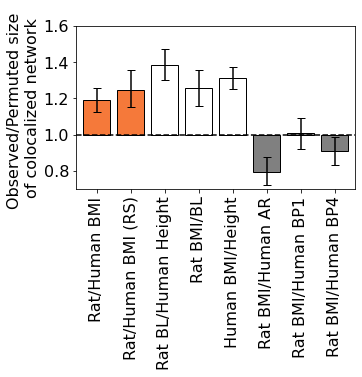

In [137]:
plt.figure(figsize=(5, 3))
plot_results = control_results.loc[["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"]]
plt.bar(x = ["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"],
       bottom= 1, height = plot_results.Mean - 1, capsize=4, edgecolor="black",
        yerr = [plot_results.Mean - plot_results.Lower, plot_results.Upper - plot_results.Mean],
       color = ["#f5793a"]*2 + ["white"]*3 + ["grey"]*3)

plt.xticks(fontsize=16, rotation=90, ticks=["rBMI-hBMI",  "BMI_RatSTRING","hHeight-rBL", "rBMI-rBL", "hBMI-hHeight", "rBMI-hAR","rBMI-hBP1", "rBMI-hBP4"], 
          labels = ["Rat/Human BMI", "Rat/Human BMI (RS)",  "Rat BL/Human Height","Rat BMI/BL","Human BMI/Height",
                   "Rat BMI/Human AR", "Rat BMI/Human BP1", "Rat BMI/Human BP4"])
plt.yticks(fontsize=16)
plt.hlines(y=1, xmin=-0.6, xmax=7.6, linestyle="dashed", color="black")
plt.ylabel("Observed/Permuted size \nof colocalized network", fontsize=16)
plt.xlim(-0.6, 7.6)
plt.ylim(0.7, 1.6)
plt.savefig("/cellar/users/snwright/Data/Transfer/rat/control_plot_July1.png", bbox_inches="tight", dpi=400)